# Implementation of a 2 Layers Neural Network

Idea:

two layer neural network implementation with custom hidden units

In [1]:
import torch
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision

from torchvision import transforms
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm as tqdm_cli
%matplotlib inline

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Class Neural Network

In [97]:
class NN(object):
    def __init__(self, input_size, output_size, test,**hidden_size):
        """Constructor class
        Args:
            input_size (int): input dim int
            hidden_size (dict): hidden dict with len 2,
                            "h1": hidden_1_dim
                            "h2": hidden_2_dim
            output_size (int): output dim especify the number of classes
        """
        self._hidden_dict = hidden_size
        self._input_dim = input_size
        self._output_dim = output_size
        self._weights = self.initialize_weights(test)
        self._grad_weights = {f"d{name}":np.zeros_like(w) for name, w in self._weights.items()}
        
    def initialize_weights(self, test):
        """Initialize weitghts
        Args:
            test (bool): bool value that indicates wether to is testing or
                    not
        """
        _weights = {}
        _dimensions = [self._input_dim] + [dim_val for 
                                           dim_val in 
                                           self._hidden_dict.values()] + [self._output_dim]
        if test:
            for i in range(len(self._hidden_dict) + 1):
                _weights[f"w{i+1}"] = np.ones(shape = (
                    _dimensions[i+1],
                    _dimensions[i] + 1
                ))
        else:
            for i in range(len(self._hidden_dict) + 1):
                e_init = np.sqrt(6)/np.sqrt(_dimensions[i+1] + _dimensions[i])
                _weights[f"w{i+1}"] = 2 * np.random.randn(
                    _dimensions[i+1],
                    _dimensions[i] + 1
                ) * e_init - e_init
        return _weights
    
            
    def forward(self, X):
        """Forward Propagation
        
        Args:
            X (numpy.array): X with shape m x n
                            m: samples
                            n: features
        """
        X_temp = np.concatenate([np.ones(shape=(X.shape[0], 1)),
                           X], axis=1)
        self.fc = {"temp_a1": X, "a1": X_temp}
        for i in range(1,len(self._hidden_dict) + 2):
            self.fc[f"z{i+1}"] = self.fc[f"a{i}"]@self._weights[f"w{i}"].T
            self.fc[f"temp_a{i+1}"] = self.sigmoid(self.fc[f"z{i+1}"])
            self.fc[f"a{i+1}"] = np.concatenate([np.ones(shape=(self.fc[f"temp_a{i+1}"].shape[0], 1)), 
                                                self.fc[f"temp_a{i+1}"]], axis=1)
            
            
    def backward(self, y_temp, last_forward_idx, m):
        _d = {}
        li = last_forward_idx
        for i in range(last_forward_idx, 1, -1):
            if i==li:
                _d[f"d{i}"] = self.fc[f"temp_a{i}"] - y_temp
            elif i>=2:
                _d[f"d{i}"] = (_d[f"d{i+1}"]@self._weights[f"w{i}"][:,1:]) * \
                            self.fc[f"temp_a{i}"]*(1-self.fc[f"temp_a{i}"])
            self._grad_weights[f"dw{i-1}"] = _d[f"d{i}"].T@self.fc[f"a{i-1}"]/m
            
       
    def loss(self, X, Y, backward=True):
        """Calculate cross entropy loss
        Args:
            X (numpy.array): X with shape m x n
                            m: samples
                            n: features
            Y (numpy.array): Y targets with shape m x 1
                            m: samples
                            in each index you have a number between
                            [0,.., c-1] where c is the number of classes
        """
        # num_samples, num_features
        m, n = X.shape
        
        # one-hot
        y_temp = np.eye(self._output_dim)[Y].squeeze()
        last_forward_idx = len(self._hidden_dict) + 2
        
        # Execute forward
        self.forward(X)
        # Execute backward
        if backward:
            self.backward(y_temp, last_forward_idx, m)
        # Calculate loss
        a = self.fc[f"temp_a{last_forward_idx}"]
        J = np.sum(np.sum(-y_temp*np.log(a) - (1-y_temp)*np.log(1-a), axis=1))
        J /= m
        self.last_forward_idx = last_forward_idx
        return J
        
    def sigmoid(self, z):
        """Sigmoid activation function:
        Args:
            z (numpy.array): an array of whatever shape
            
        Return:
            sigmoid activation function
        """
        return 1/(1 + np.exp(-z))
    
    def debug_gradients(self, X, Y, weights):
        w1_ = weights[:self._weights["w1"].size].reshape(
            self._weights["w1"].shape
        )
        w2_ = weights[self._weights["w1"].size:].reshape(
            self._weights["w2"].shape
        )
        y_temp = np.eye(2)[Y].squeeze()

        temp_a1 = X
        a1 = np.concatenate([np.ones((temp_a1.shape[0], 1)), temp_a1], axis=1)

        z2 = a1.dot(w1_.T)
        temp_a2 = self.sigmoid(z2)

        a2 = np.concatenate([np.ones((temp_a2.shape[0], 1)), temp_a2], axis=1)
        z3 = a2.dot(w2_.T)
        a3 = self.sigmoid(z3)

        loss = np.sum(np.sum(-y_temp*np.log(a3) - (1-y_temp)*np.log(1-a3), axis=1))
        loss /= x_t.shape[0]
        
        return loss

# Gradient Checking

## BackPropagation

In [98]:
x = np.array(
    [[1,0],
    [0,1],
    [0,0],
    [1,1]]
)
y = np.array(
    [[0],
    [0],
    [0],
    [1]]
)

_hdims = {"h1": 2}
nn = NN(input_size=2, output_size=2, test=True, **_hdims)
loss = nn.loss(x, y)
real_grad = np.concatenate([w.ravel() for w in nn._grad_weights.values()])

print(nn._grad_weights["dw1"])
print(nn._grad_weights["dw2"])
print(loss)

[[0.09780868 0.03325008 0.03325008]
 [0.09780868 0.03325008 0.03325008]]
[[0.18766826 0.18525136 0.18525136]
 [0.68766826 0.57027102 0.57027102]]
2.8514427656985997


## Automatic Differentiation PYTORCH

In [99]:
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

In [100]:
x_t = torch.from_numpy(x).type(torch.float64)
y_t = torch.from_numpy(y).long()

y_temp = torch.eye(2)[y_t].squeeze()
w1_ = torch.ones(*nn._weights["w1"].shape, dtype=torch.float64, requires_grad=True)
w2_ = torch.ones(*nn._weights["w2"].shape, dtype=torch.float64, requires_grad=True)

temp_a1 = x_t
a1 = torch.cat([torch.ones(temp_a1.shape[0], 1, dtype=torch.float64), temp_a1], dim=1)

z2 = a1.mm(w1_.T)
temp_a2 = sigmoid(z2)

a2 = torch.cat([torch.ones(temp_a2.shape[0], 1, dtype=torch.float64), temp_a2], dim=1)
z3 = a2.mm(w2_.T)
a3 = sigmoid(z3)

loss = torch.sum(torch.sum(-y_temp*torch.log(a3) - (1-y_temp)*torch.log(1-a3), dim=1))
loss /= x_t.shape[0]
loss.backward()

print(w1_.grad.data.numpy())
print(w2_.grad.data.numpy())
print(loss.item())

[[0.09780868 0.03325008 0.03325008]
 [0.09780868 0.03325008 0.03325008]]
[[0.18766826 0.18525136 0.18525136]
 [0.68766826 0.57027102 0.57027102]]
2.8514427656985997


## Numerical Aproximation

In [101]:
_hdims = {"h1": 2}
nn = NN(input_size=2, output_size=2, test=True, **_hdims)
h = 0.0001
weights = np.ones((nn._weights["w1"].size + nn._weights["w2"].size, ))
perturb = np.zeros_like(weights)
grad_vector = np.zeros_like(weights)
for i in range(len(perturb)):
    perturb[i] = h
    loss_r = nn.debug_gradients(x, y, weights + perturb)
    loss_l = nn.debug_gradients(x, y, weights - perturb)   
    grad_vector[i] = (loss_r - loss_l)/(2*h)
    perturb[i] = 0

dw1_ = grad_vector[:nn._weights["w1"].size].reshape(
            nn._weights["w1"].shape
)
dw2_ = grad_vector[nn._weights["w1"].size:].reshape(
    nn._weights["w2"].shape
)
print(dw1_)
print(dw2_)
print(nn.debug_gradients(x, y, weights))

[[0.09780868 0.03325008 0.03325008]
 [0.09780868 0.03325008 0.03325008]]
[[0.18766826 0.18525136 0.18525136]
 [0.68766826 0.57027102 0.57027102]]
2.8514427656985997


# Check Convergence

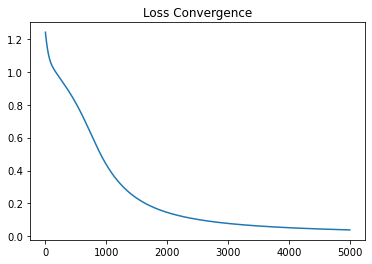

pred: 
 [[0]
 [0]
 [0]
 [1]]


In [102]:
x = np.array(
    [[1,0],
    [0,1],
    [0,0],
    [1,1]]
)
y = np.array(
    [[0],
    [0],
    [0],
    [1]]
)

_hdims = {"h1": 2}
nn = NN(input_size=2, output_size=2, test=False, **_hdims)

epochs = 5000
losses = []
lr = 0.06
for _ in tqdm_notebook(range(epochs)):
    loss = nn.loss(x, y)
    losses.append(loss)
    
    for name in nn._weights.keys():
        nn._weights[name] -= lr*nn._grad_weights[f"d{name}"]
        
plt.title("Loss Convergence")
plt.plot(losses)
plt.show()

print("pred: \n", nn.fc[f"temp_a{nn.last_forward_idx}"].argmax(axis=1).reshape(-1,1))

## MNIST

In [103]:
from scipy.io import loadmat

In [104]:
def displayData(imagenes):
    fig = plt.figure(figsize=(8, 8), constrained_layout=False)
    outer_grid = fig.add_gridspec(10, 10, wspace=0.0, hspace=0.0)
    
    
    for x in range(100):
        ax = fig.add_subplot(outer_grid[x])
        ax.imshow(imagenes[x,:,:])
        
    all_axes = fig.get_axes()

    for ax in all_axes:
        ax.set_xticks([])
        ax.set_yticks([])
        for sp in ax.spines.values():
            sp.set_visible(True)

    plt.show()

In [105]:
# Import matlab dat new
x = loadmat('ex4data1.mat')['X'] # each row contain the vector pixel of each image
y = loadmat('ex4data1.mat')['y'] # each row contain the number
X = x.reshape(x.shape[0], int(np.sqrt(x.shape[1])), int(np.sqrt(x.shape[1])))
X_dimensions = X.shape
y = np.where(y == 10, 0, y)
y = y.reshape(-1)
print(X.shape)
print(y.shape)

(5000, 20, 20)
(5000,)


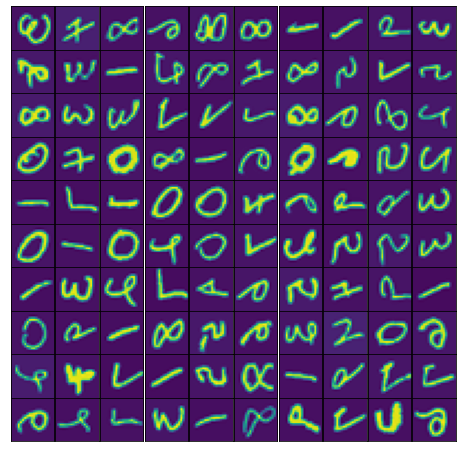

In [106]:
# For Matlab
# Parameters
X_dimensions = X.shape
m = X_dimensions[0] # No. of training examples
n = X_dimensions[1] # No. of features

# Randomly select 100 data points to display
sel = np.random.randint(m, size=100)
images = X[sel,:].reshape((100,20,20)) #Make a reshape to convert to 20x20 pixels
displayData(images)

In [107]:
def gen_batch(x, y, b_s):
    m, n = x.shape
    if m%b_s == 0:
        batch_ = m//b_s
    else:
        batch_ = m//b_s + 1
    
    for i in range(batch_):
        yield x[i*b_s:(i+1)*b_s], y[i*b_s:(i+1)*b_s]

In [111]:
X = X.reshape(-1, 20*20)
y = y.reshape(-1, 1)

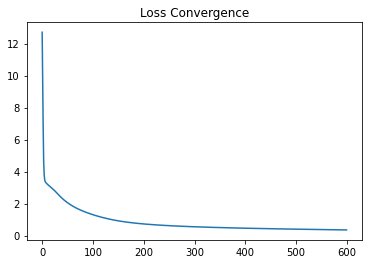

In [128]:
_hdims = {"h1": 100, "h2": 150}
nn = NN(input_size=20*20, output_size=10, test=False, **_hdims)

epochs = 600
losses = []
lr = 0.9
pbar = tqdm_notebook(total=epochs)
for _ in range(epochs):
    loss = nn.loss(X, y)
    for name in nn._weights.keys():
        nn._weights[name] -= lr*nn._grad_weights[f"d{name}"]
    losses.append(loss)
    pbar.set_description(f"Loss: {loss:0.3f}")
    pbar.update(1)
plt.title("Loss Convergence")
plt.plot(losses)
plt.show()

In [129]:
accu = sum(nn.fc[f"temp_a{nn.last_forward_idx}"].argmax(axis=1).reshape(-1,1) == y)/len(y)
print(f"accu : {accu[0]*100}%")

accu : 95.26%
